In [1]:
import phd
from phd.experiments import lengthen

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import numpy as np
import nengo
import brian.hears as bh
from scipy import stats
from nengo.utils.matplotlib import rasterplot
from nengo.utils.stdlib import Timer
from IPython.display import Audio

# Some plotting niceties
phd.plots.setup(figsize=(6, 4))

# Ensure TIMIT is extracted
timit_path = "~/phd_data/timit" #alternative:
# "~/Documents/GitHub/phd/timit/timit"
timit = phd.timit.TIMIT(timit_path)
try:
    timit.untar(os.path.expanduser("~/Dropbox/LDC93S1.tgz"))
except Exception as e:
    pass

# Plotting function used by each filter
def plot_filter(model, name):
    for sound, sname in [(noise, 'noise'), (ramp, 'ramp'), (speech, 'speech')]:
        model.audio = sound
        net = model.build(nengo.Network(seed=0))
        with net:
            # The build_periphery is in 199-200 lines of sermo.py
            ihc_p = nengo.Probe(net.periphery.ihc, synapse=None) # OUTPUT OF THE FILTER
            an_in_p = nengo.Probe(net.periphery.an.input, synapse=None) # COCHLEAR NEURONS PROJECTING DOWN AUDITORY
            # NERVE. SYNAPTIC ACTIVITY.
            an_p = nengo.Probe(net.periphery.an.add_neuron_output(), synapse=None)
        sim = nengo.Simulator(net, dt=0.0001)
        sim.run(model.t_audio)

        fig = plt.figure(figsize=(4, 8))
        grid = gs.GridSpec(3, 2, width_ratios=[40, 1])

        ax, cax = plt.subplot(grid[0, 0]), plt.subplot(grid[0, 1])
        phd.plots.cochleogram(sim.data[ihc_p], sim.trange(), model.freqs, ax=ax, cax=cax)
        ax.set_title("Inner hair cell activity")
        ax.set_xticks(())
        ax.set_xlabel("")
        print("IHC mean: %f" % np.mean(sim.data[ihc_p]))

        ax, cax = plt.subplot(grid[1, 0]), plt.subplot(grid[1, 1])
        phd.plots.cochleogram(sim.data[an_in_p], sim.trange(), model.freqs, ax=ax, cax=cax)
        ax.set_xticks(())
        ax.set_xlabel("")
        ax.set_title("IHC-AN synaptic activity")
        print("AN in mean: %f" % np.mean(sim.data[an_in_p]))

        ax = plt.subplot(grid[2, 0])
        rasterplot(sim.trange(), sim.data[an_p], ax=ax)
        ax.set_title("Spiking AN neural activity")
        #ax.set_ylim(0, net.periphery.an.n_neurons * net.periphery.an.n_ensembles)
        ax.set_ylim(0, net.periphery.an.n_neurons)
        ax.set_ylabel("Neuron")
        ax.set_xlabel("Time (s)")
        sns.despine(ax=ax)
        fig.tight_layout()
        phd.plots.savefig(fig, 'methods', '%s-%s' % (name, sname))
        
# --- Sounds
# Whitenoise
noise = phd.processes.WhiteNoise().run(t=0.4, d=1, dt=0.00002)
# Tone ramp
ramp = phd.processes.ToneRamp(t_ramp=1.).run(t=0.8, d=1, dt=0.00002)
# Speech
utt = 'deadline'
spkr = 'RRE0'
timit = phd.timit.TIMIT(timit_path)
timit.filefilt.spkr_id = spkr # ID del speaker
samples = timit.word_samples([utt])
speech = samples[utt][0]
fs_scale = 50000. / timit.fs
resample_len = int(speech.shape[0] * fs_scale)
speech = lengthen(speech, resample_len)

# --- Model
model = phd.sermo.AuditoryFeatures()
model.cepstra.n_neurons = 1  # Just looking at periphery right now
model.fs = 50000  # All extended to fs=50000 for better comparison

## Utterances

In [2]:
# Whitenoise
Audio(data=noise.ravel(), rate=50000)

In [3]:
# Ramping tone
Audio(data=ramp.ravel(), rate=50000)

In [4]:
# Speech (from TIMIT)
Audio(data=speech.ravel(), rate=50000)

## Gammatone

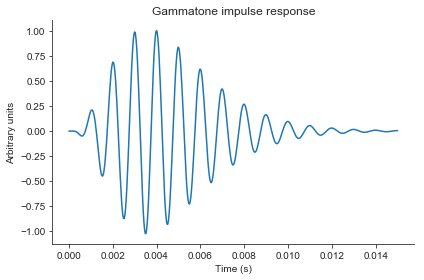

In [5]:
# Impulse response
t = np.linspace(0, 0.015, 500)
dt = t[1] - t[0]
f = 1000
order = 4
b = 1.019
erb_f = 24.7 + 0.108 * f
ir = (np.power(t, order-1) 
      * np.exp(-2 * np.pi * b * erb_f * t)
      * np.cos(2 * np.pi * f * t)) * 4.7e8
plt.plot(t, ir)
sns.despine()
plt.axis('tight')
plt.title("Gammatone impulse response")
plt.ylabel("Arbitrary units")
plt.xlabel("Time (s)")
plt.tight_layout()
phd.plots.savefig(plt.gcf(), 'methods', 'gammatone-impulse')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

IHC mean: 0.481199
AN in mean: 0.475103


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

IHC mean: 0.195776
AN in mean: 0.195672


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

IHC mean: 0.333031
AN in mean: 0.331281


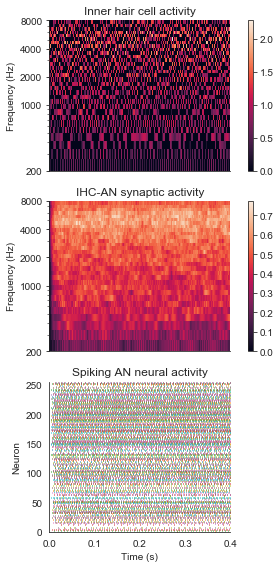

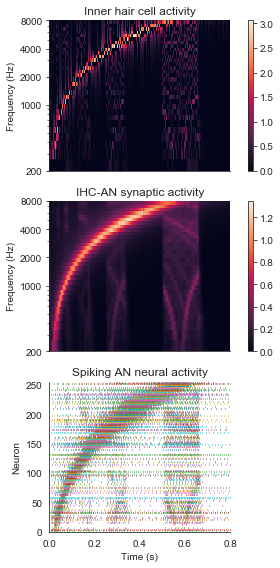

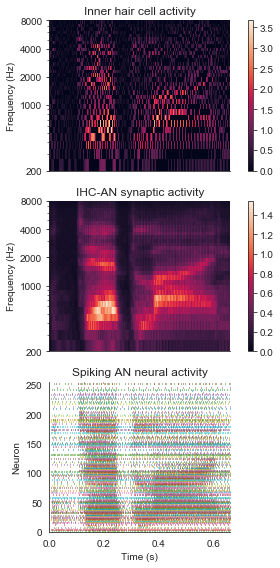

In [6]:
model.periphery.auditory_filter = 'gammatone'
plot_filter(model, 'gammatone')

In [25]:
phd.plots.savefig(f, 'results', 'ncc-ncc-derivs')

## Log Gammachirp

/Users/LeandroLV/anaconda3/envs/phd-Sermo2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/LeandroLV/anaconda3/envs/phd-Sermo2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in cos
  if __name__ == '__main__':


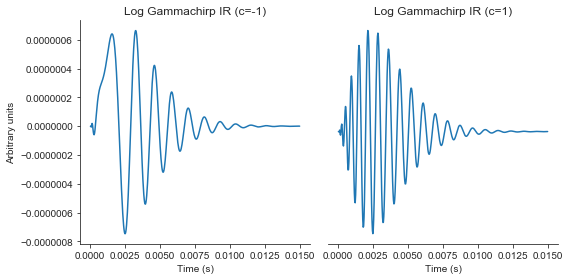

In [8]:
# Impulse response
def lg_ir(t, c):
    dt = t[1] - t[0]
    f = 1000
    b = 1.019
    erb_f = 24.7 + 0.108 * f
    return (np.power(t, 2) 
            * np.exp(-2 * np.pi * b * erb_f * t)
            * np.cos(2 * np.pi * (f * t + c * np.log(t))))

t = np.linspace(0, 0.015, 500)

fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(t, lg_ir(t, c=-1))
plt.axis('tight')
plt.title("Log Gammachirp IR (c=-1)")
plt.ylabel("Arbitrary units")
plt.xlabel("Time (s)")
sns.despine()

ax = plt.subplot(1, 2, 2)
plt.plot(t, lg_ir(t, c=1))
plt.axis('tight')
plt.title("Log Gammachirp IR (c=1)")
plt.yticks(())
plt.xlabel("Time (s)")
sns.despine(left=True, ax=ax)

plt.tight_layout()
phd.plots.savefig(plt.gcf(), 'methods', 'log-gammachirp-impulse')

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:09.                                                 
IHC mean: 0.451905
AN in mean: 0.446094
Build finished in 0:00:01.                                                      
Simulation finished in 0:00:16.                                                 
IHC mean: 0.233120
AN in mean: 0.233084
Build finished in 0:00:01.                                                      
Simulation finished in 0:00:13.                                                 
IHC mean: 0.381460
AN in mean: 0.379479


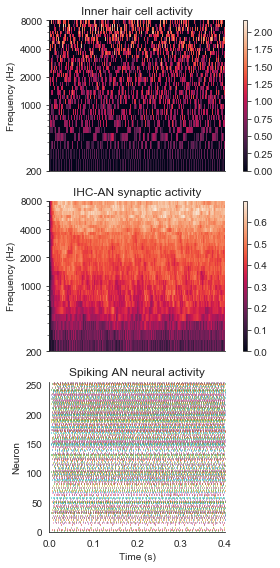

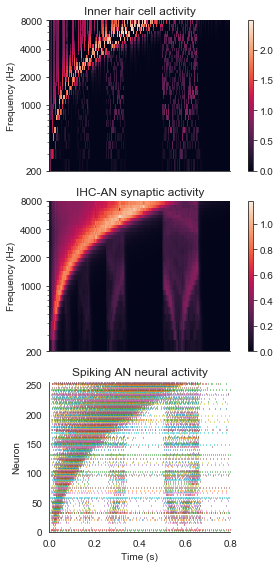

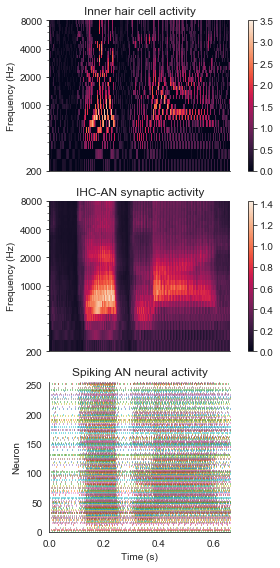

In [9]:
model.periphery.auditory_filter = 'log_gammachirp'
plot_filter(model, 'log-gammachirp')

## Dual resonance nonlinear

Build finished in 0:00:02.                                                      
Simulation finished in 0:00:11.                                                 
IHC mean: 0.475441
AN in mean: 0.469553
Build finished in 0:00:01.                                                      
Simulation finished in 0:00:21.                                                 
IHC mean: 0.273584
AN in mean: 0.273262
Build finished in 0:00:01.                                                      
Simulation finished in 0:00:18.                                                 
IHC mean: 0.306421
AN in mean: 0.304853


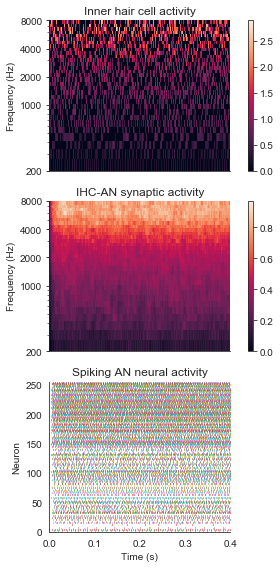

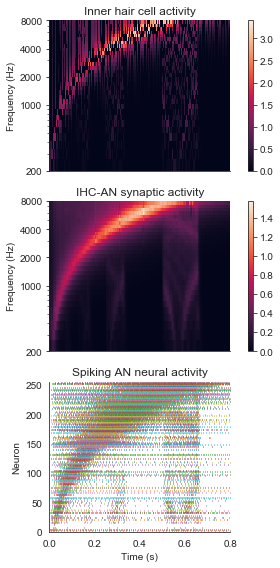

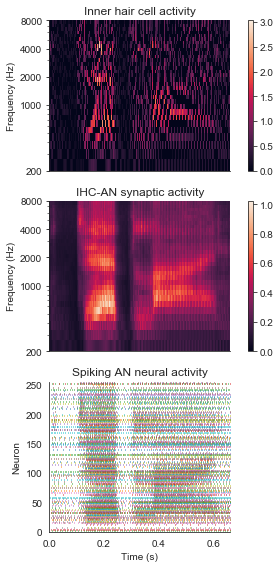

In [10]:
model.periphery.auditory_filter = 'dual_resonance'
plot_filter(model, 'dual-resonance')

## Compressive Gammachirp

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:35.                                                 
IHC mean: 0.462778
AN in mean: 0.456950
Build finished in 0:00:01.                                                      
Simulation finished in 0:01:10.                                                 
IHC mean: 0.216968
AN in mean: 0.216934
Build finished in 0:00:01.                                                      
Simulation finished in 0:00:57.                                                 
IHC mean: 0.359089
AN in mean: 0.357140


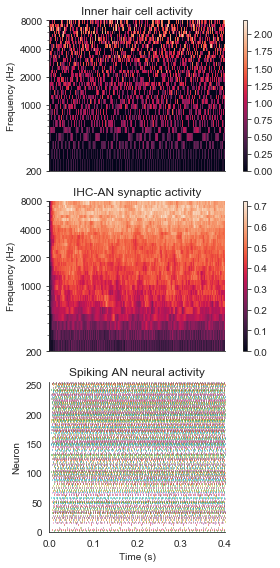

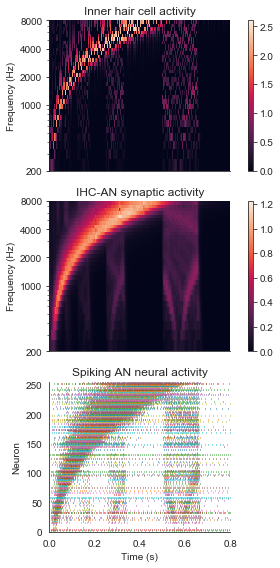

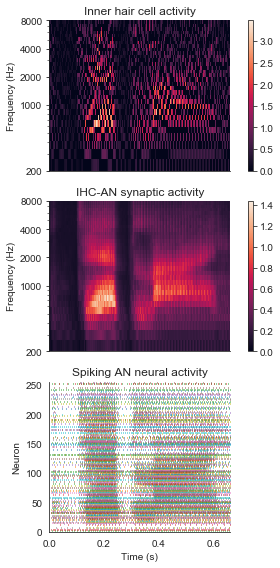

In [11]:
model.periphery.auditory_filter = 'compressive_gammachirp'
plot_filter(model, 'compressive-gammachirp')

## Tan Carney

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:31.                                                 
IHC mean: 0.404580
AN in mean: 0.399175
Build finished in 0:00:01.                                                      
Simulation finished in 0:01:04.                                                 
IHC mean: 0.122205
AN in mean: 0.122205
Build finished in 0:00:01.                                                      
Simulation finished in 0:00:55.                                                 
IHC mean: 0.342784
AN in mean: 0.340984


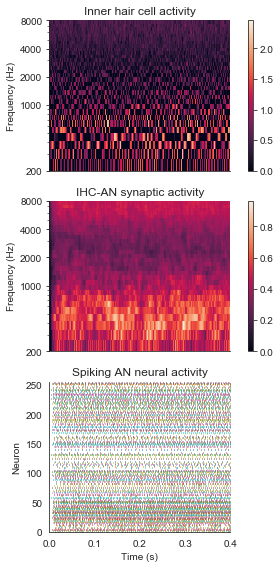

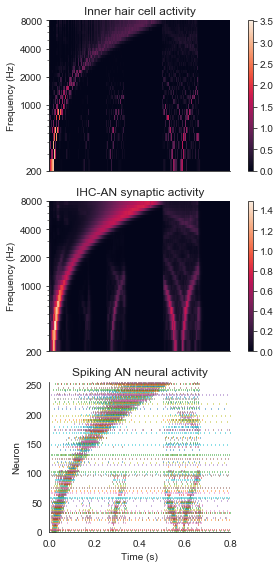

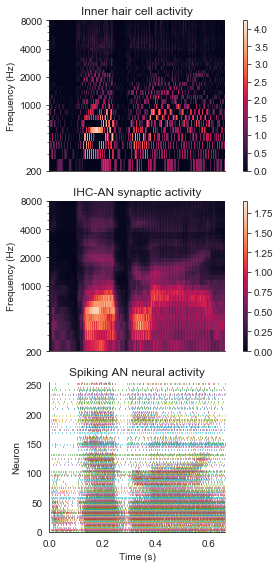

In [12]:
model.periphery.auditory_filter = 'tan_carney'
plot_filter(model, 'tan-carney')